In [4]:
pip install -r requirements.txt

  Using cached scipy-1.11.4.tar.gz (56.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      + meson setup C:\Users\jeffr\AppData\Local\Temp\pip-install-ey4yqihg\scipy_b53b2d22c1f947cfbfcff6253fe83934 C:\Users\jeffr\AppData\Local\Temp\pip-install-ey4yqihg\scipy_b53b2d22c1f947cfbfcff6253fe83934\.mesonpy-sdjp71tg -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=C:\Users\jeffr\AppData\Local\Temp\pip-install-ey4yqihg\scipy_b53b2d22c1f947cfbfcff6253fe83934\.mesonpy-sdjp71tg\meson-python-native-file.ini
      The Meson build system
      Version: 1.9.1
      Source dir: C:\Users\jeffr\AppData\Local\Temp\pip-install-ey4yqihg\scipy_b53b2d22c1f947cfbfcff6253fe83934
      Build dir: C:\Users\jeffr\AppData\Local\Temp\pip-install-ey4yqihg\scipy_b53b2d22c1f947cfbfcff6253fe83934\.mesonpy-sdjp71tg
      Build type: native build
      Project name: SciPy
      Project version: 1.11.4
      
      ..\meson.build:1:0: ER

## Read the raw Excel files

The Excel files are stored in the `datasets` folder inside this repository:
- `sales.xlsx`
- `UserReviews.xlsx`
- `ExpertReviews.xlsx`
- `metaClean43Brightspace.xlsx`

First we check the current working directory and the contents of the `datasets` folder, then we load each file into a pandas DataFrame.


In [14]:
import numpy as np
import pandas as pd
import plotnine as plotnine
from plotnine import * # generally not a good thing to do to import everything from a package. However it's ok for visualization purposes in an analysis.
import os
import scipy
import warnings
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to make jupyter print all outputs, not just the last one
from IPython.core.display import HTML # to pretty print pandas df and be able to copy them over (e.g. to ppt slides)

warnings.filterwarnings("ignore")  # to keep the output clean

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

In [ ]:
# we can get the current working directory with the following command
os.getcwd()

# we can then list the files and directories in the dataset directory
os.listdir(os.path.join('datasets')) # independent of the platform (unix, windows)



'c:\\Users\\jeffr\\OneDrive\\Documenten\\Digital Drive Business\\AI methods for business\\project map\\bjj'

['ExpertReviews.xlsx',
 'metaClean43Brightspace.xlsx',
 'sales.xlsx',
 'UserReviews.xlsx']

['ExpertReviews.xlsx', 'metaClean43Brightspace.xlsx', 'sales.xlsx', 'UserReviews.xlsx']


In [17]:
# define file paths relative to the notebook
data_folder = "datasets"

sales_path = os.path.join(data_folder, "sales.xlsx")
userreviews_path = os.path.join(data_folder, "UserReviews.xlsx")
expertreviews_path = os.path.join(data_folder, "ExpertReviews.xlsx")
meta_path = os.path.join(data_folder, "metaClean43Brightspace.xlsx")

# read the Excel files
sales_df = pd.read_excel(sales_path)
UserReviews = pd.read_excel(userreviews_path)
ExpertReviews = pd.read_excel(expertreviews_path)
meta_file_clean = pd.read_excel(meta_path)

# quick overview of shapes
for name, df in [
    ("sales_df", sales_df),
    ("UserReviews", UserReviews),
    ("ExpertReviews", ExpertReviews),
    ("meta_file_clean", meta_file_clean),
]:
    print(f"{name}: {df.shape}")


sales_df: (30612, 16)
UserReviews: (319662, 7)
ExpertReviews: (238973, 5)
meta_file_clean: (11364, 13)


# New attempt of correctly clean the data!!!!!!!!!!


# Metacritic project – EDA & data cleaning

In this notebook we load the four Metacritic datasets, do some basic EDA,  
and then apply the full cleaning pipeline we built in the Database Management course.

The main steps:

1. Load raw Excel files from the `datasets` folder.
2. Quick EDA (shapes, columns, missing values).
3. Clean and standardise:
   - sales dates and box office numbers  
   - review dates and numeric columns  
   - reviewer names and IDs  
   - movie names / URLs and movie IDs
4. Return cleaned DataFrames that are ready for modelling (regression, KNN, etc.).


In [24]:
import os
import re
import numpy as np
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  # show all outputs in a cell


## 1. Load raw data

We assume this notebook lives in the project root (the `bjj` folder)  
and that all four Excel files are in the subfolder `datasets/`:

- `UserReviews.xlsx`
- `ExpertReviews.xlsx`
- `sales.xlsx`
- `metaClean43Brightspace.xlsx`


In [25]:
# Path to the datasets folder (relative to the notebook)
data_dir = os.path.join(os.getcwd(), "datasets")
data_dir
os.listdir(data_dir)


'c:\\Users\\jeffr\\OneDrive\\Documenten\\Digital Drive Business\\AI methods for business\\project map\\bjj\\datasets'

['ExpertReviews.xlsx',
 'metaClean43Brightspace.xlsx',
 'sales.xlsx',
 'UserReviews.xlsx']

In [28]:
# Load the four Excel files
UserReviews_raw = pd.read_excel(os.path.join(data_dir, "UserReviews.xlsx"))
ExpertReviews_raw = pd.read_excel(os.path.join(data_dir, "ExpertReviews.xlsx"))
sales_raw       = pd.read_excel(os.path.join(data_dir, "sales.xlsx"))
meta_raw        = pd.read_excel(os.path.join(data_dir, "metaClean43Brightspace.xlsx"))

UserReviews_raw.shape, ExpertReviews_raw.shape, sales_raw.shape, meta_raw.shape


((319662, 7), (238973, 5), (30612, 16), (11364, 13))

## 2. Quick EDA on raw data

We first look at:

- column names
- number of rows / columns
- a few first rows
- missing values

This is just to understand what we are cleaning.


In [29]:
def print_basic_info(name, df):
    print(f"\n{name}")
    print("-" * len(name))
    print("Shape:", df.shape)
    print("Columns:", list(df.columns))
    print("\nHead():")
    display(df.head(3))
    print("\nMissing values per column:")
    display(df.isna().sum().sort_values(ascending=False).head(15))

print_basic_info("UserReviews_raw", UserReviews_raw)
print_basic_info("ExpertReviews_raw", ExpertReviews_raw)
print_basic_info("sales_raw", sales_raw)
print_basic_info("meta_raw", meta_raw)



UserReviews_raw
---------------
Shape: (319662, 7)
Columns: ['url', 'idvscore', 'reviewer', 'dateP', 'Rev', 'thumbsUp', 'thumbsTot']

Head():


,url,idvscore,reviewer,dateP,Rev,thumbsUp,thumbsTot
0,https://www.metacritic.com/movie/bronson,8,'Longbottom94',"'Apr 25, 2013'",'Many have dismissed this film for not explor...,2,2
1,https://www.metacritic.com/movie/bronson,9,'MartinB',"'Oct 13, 2009'",'Anyone who doesn t like this movie simply ju...,0,1
2,https://www.metacritic.com/movie/bronson,10,'Jaakko',"'Jul 19, 2012'",'Not sure what to think at this film at first...,1,1



Missing values per column:


thumbsUp     3580
thumbsTot    3576
Rev          3413
dateP        3413
reviewer     3407
idvscore     3404
url             0
dtype: int64


ExpertReviews_raw
-----------------
Shape: (238973, 5)
Columns: ['url', 'idvscore', 'reviewer', 'dateP', 'Rev']

Head():


,url,idvscore,reviewer,dateP,Rev
0,https://www.metacritic.com/movie/bronson,100.0,"""Andrew O'Hehir""",None,'Bronson owes a little or a lot to Kubrick s ...
1,https://www.metacritic.com/movie/bronson,90.0,'A.O. Scott',None,'Bronson invites you to admire its protagonis...
2,https://www.metacritic.com/movie/bronson,90.0,None,None,'Whether it s Peterson/Bronson s more theatri...



Missing values per column:


idvscore    2
dateP       2
reviewer    2
Rev         2
url         0
dtype: int64


sales_raw
---------
Shape: (30612, 16)
Columns: ['year', 'release_date', 'title', 'genre', 'international_box_office', 'domestic_box_office', 'worldwide_box_office', 'production_budget', 'Unnamed: 8', 'opening_weekend', 'theatre_count', 'avg run per theatre', 'runtime', 'keywords', 'creative_type', 'url']

Head():


,year,release_date,title,genre,international_box_office,domestic_box_office,worldwide_box_office,production_budget,Unnamed: 8,opening_weekend,theatre_count,avg run per theatre,runtime,keywords,creative_type,url
0,2000,January 1st,Bakha Satang,Drama,76576.0,NaN,76576.0,NaN,NaN,NaN,NaN,NaN,129.0,NaN,Contemporary Fiction,https://www.the-numbers.com/movie/Bakha-Satang...
1,2001,January 12th,Antitrust,Thriller/Suspense,6900000.0,10965209.0,17865209.0,30000000.0,NaN,5486209.0,2433.0,3.1,NaN,NaN,Contemporary Fiction,https://www.the-numbers.com/movie/Antitrust
2,2000,January 28th,Santitos,NaN,NaN,378562.0,NaN,NaN,NaN,NaN,NaN,NaN,105.0,NaN,NaN,https://www.the-numbers.com/movie/Santitos



Missing values per column:


Unnamed: 8                  30612
production_budget           26132
opening_weekend             19683
avg run per theatre         19660
theatre_count               19649
domestic_box_office         18728
keywords                    18095
worldwide_box_office         9037
international_box_office     9037
runtime                      6053
creative_type                3945
genre                        1704
title                           8
year                            0
release_date                    0
dtype: int64


meta_raw
--------
Shape: (11364, 13)
Columns: ['url', 'title', 'studio', 'rating', 'runtime', 'cast', 'director', 'genre', 'summary', 'awards', 'metascore', 'userscore', 'RelDate']

Head():


,url,title,studio,rating,runtime,cast,director,genre,summary,awards,metascore,userscore,RelDate
0,https://www.metacritic.com/movie/!women-art-re...,!Women Art Revolution,Hotwire Productions,| Not Rated,83.0,NaN,Lynn Hershman-Leeson,Documentary,NaN,NaN,70,NaN,2011-06-01
1,https://www.metacritic.com/movie/10-cloverfiel...,10 Cloverfield Lane,Paramount Pictures,| PG-13,104.0,"John Gallagher Jr.,John Goodman,Mary Elizabeth...",Dan Trachtenberg,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror","Waking up from a car accident, a young woman (...","#18MostDiscussedMovieof2016 , #1MostSharedMovi...",76,7.7,2016-03-11
2,https://www.metacritic.com/movie/10-items-or-less,10 Items or Less,Click Star,| R,82.0,"Jonah Hill,Morgan Freeman,Paz Vega",Brad Silberling,"Drama,Comedy,Romance",While researching a role as a supermarket mana...,NaN,54,5.8,2006-12-01



Missing values per column:


awards       6977
summary      5897
cast         3702
userscore    2105
rating       1067
studio        350
runtime       255
genre          20
director       14
title           0
url             0
metascore       0
RelDate         0
dtype: int64

### Reflection on the raw datasets

Based on the first EDA, we can already see which problems exist in each table and what type of cleaning steps we need next.

#### UserReviews_raw

- Shape: 319,662 rows and 7 columns. This is a large table with one row per user review.
- Important columns:  
  - `url` links the review to a specific movie. There are no missing values here, so this is a good key.  
  - `idvscore` is a user score, but currently comes from Excel as text with quotes. We need it as a clean numeric column.  
  - `reviewer` contains usernames, but there are about 3,400 missing values. We do not want empty reviewer names in the final data.  
  - `dateP` is a text date (for example `'Apr 25, 2013'`) with quotes and also has about 3,400 missing values.  
  - `Rev` is the review text. We will mainly keep this as a text field, but we want to know where reviews are missing.  
  - `thumbsUp` and `thumbsTot` are sometimes missing (around 3,500 rows). Later we want to create an extra variable `thumbsDown` from these.

Cleaning implications:
- Convert `dateP` into a proper `datetime` column and keep invalid dates as `NaT`.  
- Clean the `reviewer` column and replace missing or empty names with `"Unknown Reviewer"`.  
- Convert `idvscore`, `thumbsUp` and `thumbsTot` into numeric using `get_numeric_value` and `clean_numeric_columns`.  
- Create a new variable `thumbsDown` from `thumbsTot - thumbsUp` using `calculate_thumbs_down`.  
- For this we use helpers like `clean_user_review_dates`, `clean_reviewer_column`, `clean_numeric_columns` and `calculate_thumbs_down`.

#### ExpertReviews_raw

- Shape: 238,973 rows and 5 columns, similar to the user reviews but without thumbs columns.  
- Almost no missing values: only 2 missing for `idvscore`, `reviewer`, `dateP` and `Rev`.  
- `dateP` is often `None` and must be converted to `datetime` just like in the user table.  
- `reviewer` has a few missing values that we again want to replace with `"Unknown Reviewer"`.

Cleaning implications:
- We want the same behaviour as in `UserReviews_raw` so both tables are consistent and easier to combine later.  
- We mainly use `clean_expert_review_dates`, `clean_reviewer_column` and `clean_numeric_columns`.  
- We also create unique IDs for reviewers and reviews with `create_expert_ids` and `create_review_ids`.

#### sales_raw

- Shape: 30,612 rows and 16 columns. This is our box office / financial table.  
- A lot of missing values in `production_budget`, `opening_weekend`, `theatre_count`, `avg run per theatre` and also in the box office columns.  
- Column `Unnamed: 8` is completely empty and can be dropped later.  
- `release_date` is a free-form text date (for example `"January 1st"`) and needs to be converted to `datetime`.  
- `international_box_office`, `domestic_box_office`, `worldwide_box_office` and `production_budget` are numeric amounts but come as text from Excel.  
- `url` is present and has no missing values, which is useful as a link to the movie.

Cleaning implications:
- Convert all monetary and count columns to numeric using `get_numeric_value` and `clean_numeric_columns`.  
- Create one total revenue measure `total_box_office` using `calculate_total_box_office`.  
- Convert `release_date` to a clean `releasedate` column via `clean_sales_dates`, with a fallback on `year` where needed.  
- Drop the completely empty `Unnamed: 8` column.

#### meta_raw

- Shape: 11,364 rows and 13 columns. This is our movie-level metadata table.  
- Important columns: `url`, `title`, `studio`, `rating`, `runtime`, `metascore`, `userscore`, `RelDate`.  
- `url`, `title`, `metascore` and `RelDate` have no missing values, which is good for linking and modelling.  
- Many missing values in `awards`, `summary` and `cast`. These are mainly descriptive and not strictly required for a first prediction model.  
- `RelDate` is already in a clean date format.

Cleaning implications:
- Standardise the release date into a single `releasedate` column using `standardize_meta_dates` so it aligns with the other tables.  
- Keep text fields like `summary`, `awards` and `cast` as they are for now, but we know they contain many missings.  
- Treat `runtime`, `metascore` and `userscore` as important numeric features for later modelling.

#### Across all tables

- All tables have a `url` column, and it is never missing. This makes `url` a natural starting point for linking movies across datasets.  
- However, URLs and titles are not always written in exactly the same way, and small spelling or formatting differences can cause duplicate or mismatched movies.  
  Because of this, we need a separate cleaning step to standardise movie names and create a single consistent `movie_id`.

Therefore we introduce the following helper functions:

- `clean_movie_name` and `extract_title_from_url` to standardise movie names and extract readable titles from URLs.  
- `collect_all_movie_records`, `create_movie_dimension_table` and `add_movie_ids_to_datasets` to build a movie dimension table (`movie_key`) with a unique `movie_id` per cleaned movie name and to merge that ID back into all datasets.  
- `create_all_ids` to create stable IDs for users, experts and individual reviews.

After these cleaning steps:

- dates use a consistent `datetime` format across tables,  
- numeric fields are properly numeric instead of messy text,  
- reviewers and reviews have unique IDs,  
- and all tables can be joined via a single `movie_id`.

This cleaned structure is then ready for feature engineering and machine learning models (for example regression or KNN) at the movie level.


## 3. Helper functions for safe column access and numeric cleaning

These come from the DBM cleaning script and make the code more robust:

- `safe_column_access` – check if a column exists
- `get_numeric_value` – turn messy text into numbers
- `clean_numeric_columns` – apply numeric cleaning to multiple columns
- `calculate_total_box_office` – sum domestic + international box office
- `calculate_thumbs_down` – create `thumbsDown = thumbsTot - thumbsUp`


In [30]:
def safe_column_access(df, column_name, default=np.nan):
    """Return a column if it exists, otherwise a Series filled with a default value."""
    if column_name in df.columns:
        return df[column_name]
    else:
        return pd.Series([default] * len(df), index=df.index)

def get_numeric_value(text_series):
    """
    Clean a text column and convert it to numeric.
    Removes commas, currency symbols and anything non-numeric.
    """
    clean = (
        text_series.astype(str)
        .str.replace(",", "", regex=False)
        .str.replace("$", "", regex=False)
        .str.replace("€", "", regex=False)
        .str.replace(r"[^\d\.\-]", "", regex=True)
    )
    return pd.to_numeric(clean, errors="coerce")

def clean_numeric_columns(df, columns):
    """Apply numeric cleaning to a list of columns."""
    for col in columns:
        if col in df.columns:
            df[col] = get_numeric_value(df[col])

def calculate_total_box_office(sales_df):
    """
    Create a single numeric column for total box office.
    Uses existing numeric columns if they are present.
    """
    print("Calculating total box office sales...")
    for col in [
        "domestic_box_office",
        "international_box_office",
        "worldwide_box_office",
        "production_budget",
        "opening_weekend",
    ]:
        if col in sales_df.columns:
            sales_df[col] = get_numeric_value(sales_df[col])

    if "worldwide_box_office" in sales_df.columns:
        sales_df["total_box_office"] = sales_df["worldwide_box_office"]
    else:
        sales_df["total_box_office"] = (
            safe_column_access(sales_df, "domestic_box_office", 0).fillna(0)
            + safe_column_access(sales_df, "international_box_office", 0).fillna(0)
        )

def calculate_thumbs_down(df):
    """Create thumbsDown from thumbsTot and thumbsUp if both are available."""
    if all(col in df.columns for col in ["thumbsUp", "thumbsTot"]):
        df["thumbsUp"] = get_numeric_value(df["thumbsUp"])
        df["thumbsTot"] = get_numeric_value(df["thumbsTot"])
        df["thumbsDown"] = df["thumbsTot"] - df["thumbsUp"]


## 4. Date cleaning

We want:

- sales release dates as proper `datetime`
- review dates as `datetime`
- meta data release dates as `datetime`

The idea is the same as in the DBMS script:
first try a direct parse, then fall back to a combination of year + date text.


In [31]:
def clean_date_text(series):
    """
    Try to parse messy date strings into real dates.
    Falls back to NaT when parsing fails.
    """
    # Strip whitespace
    text = series.astype(str).str.strip()

    # Replace obvious non-dates
    repl = ["nan", "none", "null", "", "not yet released", "tbd", "unknown"]
    text = text.str.lower().replace(repl, np.nan)

    # Let pandas try to parse (it will try many formats)
    clean_dates = pd.to_datetime(text, errors="coerce")

    return clean_dates

def clean_sales_dates(sales_df):
    """
    Create a clean release date column for the sales data.
    Uses 'release_date' and, as backup, 'year'.
    """
    print("Cleaning sales release dates...")

    release_date = safe_column_access(sales_df, "release_date")
    year_col = safe_column_access(sales_df, "year")

    clean_dates = clean_date_text(release_date)

    # If parsing failed but we at least have a year, try year-only
    missing_mask = clean_dates.isna() & year_col.notna()
    if missing_mask.any():
        backup = pd.to_datetime(year_col[missing_mask].astype(str), format="%Y", errors="coerce")
        clean_dates.loc[missing_mask] = backup

    sales_df["releasedate"] = clean_dates
    return sales_df["releasedate"]

def clean_expert_review_dates(df):
    """Standardize expert review dates."""
    if "dateP" in df.columns:
        df["expert_review_date"] = pd.to_datetime(df["dateP"], errors="coerce")
    elif "date" in df.columns:
        df["expert_review_date"] = pd.to_datetime(df["date"], errors="coerce")
    else:
        df["expert_review_date"] = pd.NaT

def clean_user_review_dates(df):
    """Standardize user review dates."""
    if "dateP" in df.columns:
        # original script formatted as YYYY-MM-DD string, then back to datetime
        df["dateP"] = pd.to_datetime(df["dateP"], errors="coerce").dt.strftime("%Y-%m-%d")
        df["user_review_date"] = pd.to_datetime(df["dateP"], errors="coerce")
    else:
        df["user_review_date"] = pd.NaT

def standardize_meta_dates(meta_df):
    """
    Standardise release date in the meta dataset.
    In your original file this was mostly cleaned already, but we enforce datetime.
    """
    # Try a few common column names – adjust if your actual column name is different
    for col in ["RelDate", "release_date", "releasedate"]:
        if col in meta_df.columns:
            meta_df["releasedate"] = clean_date_text(meta_df[col])
            return meta_df["releasedate"]

    # Fallback: no clear date column, create empty
    meta_df["releasedate"] = pd.NaT
    return meta_df["releasedate"]

def create_movie_date_mapping(sales_df, meta_df):
    """
    Build a mapping from cleaned movie name to release date using
    both sales and meta datasets.
    """
    # We will fill this mapping later once we have cleaned movie names,
    # so for now this returns an empty dict. We keep the function for structure.
    return {}


## 5. Reviewer names and IDs

We reuse the logic from DBMS:

- make sure reviewer names are never empty
- optionally lower-case or strip noise
- create `UserID` and `ExpertID`
- create sequential IDs for each review


In [32]:
def clean_reviewer_name(name):
    """Ensure reviewer names are never null or empty."""
    if pd.isna(name) or name is None:
        return "Unknown Reviewer"
    str_name = str(name).strip()
    if str_name in ["", "nan", "NaN", "None", "null"]:
        return "Unknown Reviewer"
    return str_name

def clean_reviewer_column(df):
    """Apply reviewer name cleaning to a DataFrame that has a 'reviewer' column."""
    if "reviewer" in df.columns:
        df["reviewer"] = df["reviewer"].apply(clean_reviewer_name)

def create_user_ids(UserReviews):
    """Create UserID for user reviews (group by reviewer name)."""
    if "reviewer" in UserReviews.columns:
        clean_reviewer_column(UserReviews)
        UserReviews["UserID"] = UserReviews["reviewer"].astype(str).str.strip().replace("", "Unknown Reviewer")
        UserReviews["UserID"] = UserReviews.groupby("UserID").ngroup() + 1
    else:
        UserReviews["reviewer"] = "Unknown Reviewer"
        UserReviews["UserID"] = range(1, len(UserReviews) + 1)

def create_expert_ids(ExpertReviews):
    """Create ExpertID for expert reviews (group by reviewer name)."""
    if "reviewer" in ExpertReviews.columns:
        clean_reviewer_column(ExpertReviews)
        ExpertReviews["ExpertID"] = ExpertReviews["reviewer"].astype(str).str.strip().replace("", "Unknown Reviewer")
        ExpertReviews["ExpertID"] = ExpertReviews.groupby("ExpertID").ngroup() + 1
    else:
        ExpertReviews["reviewer"] = "Unknown Reviewer"
        ExpertReviews["ExpertID"] = range(1, len(ExpertReviews) + 1)

def create_review_ids(df, id_column):
    """Create simple sequential IDs for each row."""
    df[id_column] = range(1, len(df) + 1)

def create_all_ids(UserReviews, ExpertReviews):
    """Run all ID creation steps."""
    print("Creating unique IDs.")
    create_user_ids(UserReviews)
    create_expert_ids(ExpertReviews)
    create_review_ids(UserReviews, "UserReviewID")
    create_review_ids(ExpertReviews, "ExpertReviewID")


## 6. Movie name cleaning and movie IDs

Now we fix the movie names to avoid duplicates caused by spelling / url differences.

Steps (same idea as the DBMS script):

1. Use the `url` column as base, or fall back to a title column.
2. Clean the text:
   - lowercase
   - remove trailing slashes and file extensions
   - remove year, brackets, common spam words like "watch", "online", etc.
3. Collect all movie references from all datasets.
4. Create a movie dimension table with a unique `movie_id` per cleaned name.
5. Add `movie_id` back to each dataset.


In [33]:
def clean_movie_name(text):
    """Make movie names consistent for matching across datasets."""
    if pd.isna(text) or text is None:
        return ""
    name = str(text).lower().strip().rstrip("/")
    name = name.rsplit("/", 1)[-1]          # take last part after slash (for URLs)
    name = name.replace("-", " ").replace("_", " ")
    # remove brackets content
    name = re.sub(r"\([^)]*\)|\[[^\]]*\]", "", name)
    # remove year at end like "(2019)" or "2019"
    name = re.sub(r"[\(\[]\s*(?:19|20)\d{2}[^)\]]*\s*[\)\]]\s*$|(?:19|20)\d{2}\s*$", "", name)
    # keep only letters, digits, spaces, hyphen and apostrophe
    name = re.sub(r"[^a-z0-9\s\-']", "", name)
    # collapse spaces
    name = re.sub(r"\s+", " ", name).strip()
    return name

def extract_title_from_url(text):
    """
    Extract a nice display title from a URL or raw text,
    mainly for presentation (not for matching).
    """
    if pd.isna(text) or text is None:
        return "Unknown Movie"
    original_text = str(text).strip()
    # If this does not look like a URL, clean it and capitalise
    if not any(ind in original_text.lower() for ind in ["http", "www.", ".com", ".net", ".org"]):
        title = original_text
        title = re.sub(r"\([^)]*\)|\[[^\]]*\]", "", title)
        title = re.sub(r"[\(\[]\s*(?:19|20)\d{2}[^)\]]*\s*[\)\]]\s*$|(?:19|20)\d{2}\s*$", "", title)
        title = re.sub(r"[^a-zA-Z0-9\s]", "", title)
        title = re.sub(r"\s+", " ", title).strip()
        if title:
            title = " ".join(word.capitalize() for word in title.split())
            return title
        else:
            return "Unknown Movie"

    # URL case
    url_text = original_text.lower()
    if "/" in url_text:
        path_part = url_text.split("/")[-1]
    else:
        path_part = url_text
    path_part = re.sub(r"\.html?$", "", path_part)
    path_part = re.sub(r"\.php$", "", path_part)
    title = path_part.replace("-", " ").replace("_", " ")
    # remove square brackets etc
    title = re.sub(r"\[[^\]]*\]", "", title)
    title = re.sub(r"[^a-zA-Z0-9\s]", "", title)
    title = re.sub(r"\s+", " ", title).strip()
    if title:
        title = " ".join(word.capitalize() for word in title.split())
        return title
    else:
        return "Unknown Movie"

def collect_all_movie_records(datasets, dataset_configs):
    """Collect all movie names from all datasets for ID generation."""
    all_movie_records = []
    for df_name, df in datasets.items():
        config = dataset_configs.get(df_name, {})
        source_col = config.get("source_column", "url")
        if source_col not in df.columns:
            continue

        cleaned = df[source_col].apply(clean_movie_name)
        display_titles = df[source_col].apply(extract_title_from_url)

        temp = pd.DataFrame(
            {
                "dataset": df_name,
                "original_text": df[source_col],
                "cleaned_name": cleaned,
                "display_title": display_titles,
            }
        )
        all_movie_records.append(temp)

    if not all_movie_records:
        return pd.DataFrame(columns=["dataset", "original_text", "cleaned_name", "display_title"])

    return pd.concat(all_movie_records, ignore_index=True)

def create_movie_dimension_table(all_movie_records):
    """Create the movie dimension table with unique movie IDs."""
    movie_key = (
        all_movie_records[["cleaned_name", "display_title"]]
        .drop_duplicates()
        .reset_index(drop=True)
    )
    movie_key = movie_key[movie_key["cleaned_name"] != ""].reset_index(drop=True)
    movie_key["movie_id"] = range(1, len(movie_key) + 1)
    # Reorder columns
    movie_key = movie_key[["movie_id", "cleaned_name", "display_title"]]
    return movie_key

def add_movie_ids_to_datasets(datasets, movie_key, dataset_configs):
    """Merge movie_id back into each dataset based on cleaned movie name."""
    movie_lookup = movie_key[["movie_id", "cleaned_name"]].copy()

    for df_name, df in datasets.items():
        config = dataset_configs.get(df_name, {})
        source_col = config.get("source_column", "url")

        if source_col not in df.columns:
            print(f"  Skipping {df_name}: column '{source_col}' not found.")
            continue

        tmp = df[source_col].apply(clean_movie_name)
        df["cleaned_movie_name"] = tmp

        df_merged = df.merge(
            movie_lookup,
            how="left",
            left_on="cleaned_movie_name",
            right_on="cleaned_name",
        )
        df["movie_id"] = df_merged["movie_id"]
        datasets[df_name] = df  # update

def create_movie_ids_fixed(datasets):
    """
    Wrapper to generate a consistent movie_id across all datasets.
    Returns the movie dimension table.
    """
    print("Generating consistent movie IDs across all datasets.")

    dataset_configs = {
        "UserReviews": {"source_column": "url"},
        "ExpertReviews": {"source_column": "url"},
        "sales_df": {"source_column": "url"},
        "meta_file_clean": {"source_column": "url"},
    }

    all_movie_records = collect_all_movie_records(datasets, dataset_configs)
    print(f"  Found {len(all_movie_records)} total movie references")

    movie_key = create_movie_dimension_table(all_movie_records)
    print(f"  Identified {len(movie_key)} unique movies")

    add_movie_ids_to_datasets(datasets, movie_key, dataset_configs)

    # Simple coverage info
    for name, df in datasets.items():
        total = len(df)
        mapped = df["movie_id"].notna().sum()
        print(f"  {name}: mapped {mapped}/{total} records to movie_ids")

    return movie_key


## 7. Put everything together: full cleaning pipeline

Now we combine the pieces in one function:

1. Copy raw DataFrames (so we keep the originals).
2. Clean sales dates and box office.
3. Clean review numeric columns and thumbs.
4. Clean review dates.
5. Create IDs for users, experts and reviews.
6. Generate consistent `movie_id`s and a movie dimension table.
7. Return cleaned DataFrames and the `movie_key` table.


In [35]:
def process_review_data(UserReviews, ExpertReviews):
    """Process numeric columns, thumbs and dates for review datasets."""
    print("Processing review data...")

    # Numeric columns in both review sets (idvscore etc.)
    numeric_cols_common = ["idvscore"]
    # User specific numeric columns
    user_numeric_extra = ["thumbsUp", "thumbsTot"]
    # LIWC etc: treat as numeric if present
    liwc_like_cols = [
        "WC", "Analytic", "Clout", "Authentic", "Tone",
        "posemo", "negemo"
    ]

    # UserReviews
    user_numeric = [c for c in numeric_cols_common + user_numeric_extra + liwc_like_cols if c in UserReviews.columns]
    clean_numeric_columns(UserReviews, user_numeric)
    calculate_thumbs_down(UserReviews)
    clean_user_review_dates(UserReviews)

    # ExpertReviews
    expert_numeric = [c for c in numeric_cols_common + liwc_like_cols if c in ExpertReviews.columns]
    clean_numeric_columns(ExpertReviews, expert_numeric)
    clean_expert_review_dates(ExpertReviews)

def process_all_datasets_for_ai(UserReviews_raw, ExpertReviews_raw, sales_raw, meta_raw):
    """
    High level function that applies the full DBM cleaning logic
    but returns DataFrames for AI modelling instead of loading into a database.
    """
    # Work on copies so we never change the raw input
    UserReviews = UserReviews_raw.copy()
    ExpertReviews = ExpertReviews_raw.copy()
    sales_df     = sales_raw.copy()
    meta_file_clean = meta_raw.copy()

    print("Cleaning sales data...")
    clean_sales_dates(sales_df)
    calculate_total_box_office(sales_df)

    process_review_data(UserReviews, ExpertReviews)
    create_all_ids(UserReviews, ExpertReviews)

    print("Standardizing meta release dates...")
    standardize_meta_dates(meta_file_clean)

    print("Generating movie IDs...")
    datasets = {
        "UserReviews": UserReviews,
        "ExpertReviews": ExpertReviews,
        "sales_df": sales_df,
        "meta_file_clean": meta_file_clean,
    }
    movie_key = create_movie_ids_fixed(datasets)

    print("\nBasic data processing complete!")
    return datasets, movie_key


## 8. Run the cleaning and inspect results

Now we actually run the pipeline and check:

- cleaned shapes
- head of the movie dimension table
- example of a cleaned dataset (e.g. `UserReviews`).


In [36]:
datasets_clean, movie_key = process_all_datasets_for_ai(
    UserReviews_raw,
    ExpertReviews_raw,
    sales_raw,
    meta_raw,
)

UserReviews_clean = datasets_clean["UserReviews"]
ExpertReviews_clean = datasets_clean["ExpertReviews"]
sales_clean = datasets_clean["sales_df"]
meta_clean = datasets_clean["meta_file_clean"]

UserReviews_clean.shape, ExpertReviews_clean.shape, sales_clean.shape, meta_clean.shape, movie_key.shape


Cleaning sales data...
Cleaning sales release dates...
Calculating total box office sales...
Processing review data...
Creating unique IDs.
Standardizing meta release dates...
Generating movie IDs...
Generating consistent movie IDs across all datasets.
  Found 600611 total movie references
  Identified 36660 unique movies
  UserReviews: mapped 319071/319662 records to movie_ids
  ExpertReviews: mapped 238820/238973 records to movie_ids
  sales_df: mapped 30597/30612 records to movie_ids
  meta_file_clean: mapped 11355/11364 records to movie_ids

Basic data processing complete!


((319662, 13), (238973, 10), (30612, 20), (11364, 16), (36660, 3))

In [37]:
print("Movie dimension table (movie_key):")
movie_key.head()


Movie dimension table (movie_key):


,movie_id,cleaned_name,display_title
0,1,bronson,Bronson
1,2,disgrace,Disgrace
2,3,a screaming man,A Screaming Man
3,4,lovers of hate,Lovers Of Hate
4,5,phil ochs there but for fortune,Phil Ochs There But For Fortune


In [38]:
print_basic_info("UserReviews_clean", UserReviews_clean)



UserReviews_clean
-----------------
Shape: (319662, 13)
Columns: ['url', 'idvscore', 'reviewer', 'dateP', 'Rev', 'thumbsUp', 'thumbsTot', 'thumbsDown', 'user_review_date', 'UserID', 'UserReviewID', 'cleaned_movie_name', 'movie_id']

Head():


,url,idvscore,reviewer,dateP,Rev,thumbsUp,thumbsTot,thumbsDown,user_review_date,UserID,UserReviewID,cleaned_movie_name,movie_id
0,https://www.metacritic.com/movie/bronson,8.0,'Longbottom94',2013-04-25,'Many have dismissed this film for not explor...,2.0,2.0,0.0,2013-04-25,40545,1,bronson,1.0
1,https://www.metacritic.com/movie/bronson,9.0,'MartinB',2009-10-13,'Anyone who doesn t like this movie simply ju...,0.0,1.0,1.0,2009-10-13,43490,2,bronson,1.0
2,https://www.metacritic.com/movie/bronson,10.0,'Jaakko',2012-07-19,'Not sure what to think at this film at first...,1.0,1.0,0.0,2012-07-19,30354,3,bronson,1.0



Missing values per column:


thumbsDown            3582
thumbsUp              3581
thumbsTot             3581
dateP                 3413
Rev                   3413
user_review_date      3413
idvscore              3409
movie_id               591
url                      0
reviewer                 0
UserID                   0
UserReviewID             0
cleaned_movie_name       0
dtype: int64

## Global check of cleaned tables

In this section we get a quick overview of all cleaned tables:
- shape and a few column names
- first rows
- fraction of missing values per column (top 10)
- optional bar plot of missing values per table


In [39]:
cleaned_datasets = {
    "UserReviews_clean": UserReviews_clean,
    "ExpertReviews_clean": ExpertReviews_clean,
    "sales_clean": sales_clean,
    "meta_clean": meta_clean,
    "movie_key": movie_key,
}

for name, df in cleaned_datasets.items():
    print("=" * 100)
    print(name)
    print("- Shape:", df.shape)
    print("- First columns:", list(df.columns)[:10], "...")
    print("\nHead():")
    display(df.head(3))

    print("\nMissing values (fraction, top 10):")
    missing_frac = df.isna().mean().sort_values(ascending=False).head(10)
    display(missing_frac)

    print("\n\n")


UserReviews_clean
- Shape: (319662, 13)
- First columns: ['url', 'idvscore', 'reviewer', 'dateP', 'Rev', 'thumbsUp', 'thumbsTot', 'thumbsDown', 'user_review_date', 'UserID'] ...

Head():


,url,idvscore,reviewer,dateP,Rev,thumbsUp,thumbsTot,thumbsDown,user_review_date,UserID,UserReviewID,cleaned_movie_name,movie_id
0,https://www.metacritic.com/movie/bronson,8.0,'Longbottom94',2013-04-25,'Many have dismissed this film for not explor...,2.0,2.0,0.0,2013-04-25,40545,1,bronson,1.0
1,https://www.metacritic.com/movie/bronson,9.0,'MartinB',2009-10-13,'Anyone who doesn t like this movie simply ju...,0.0,1.0,1.0,2009-10-13,43490,2,bronson,1.0
2,https://www.metacritic.com/movie/bronson,10.0,'Jaakko',2012-07-19,'Not sure what to think at this film at first...,1.0,1.0,0.0,2012-07-19,30354,3,bronson,1.0



Missing values (fraction, top 10):


thumbsDown          0.011206
thumbsUp            0.011202
thumbsTot           0.011202
dateP               0.010677
Rev                 0.010677
user_review_date    0.010677
idvscore            0.010664
movie_id            0.001849
url                 0.000000
reviewer            0.000000
dtype: float64




ExpertReviews_clean
- Shape: (238973, 10)
- First columns: ['url', 'idvscore', 'reviewer', 'dateP', 'Rev', 'expert_review_date', 'ExpertID', 'ExpertReviewID', 'cleaned_movie_name', 'movie_id'] ...

Head():


,url,idvscore,reviewer,dateP,Rev,expert_review_date,ExpertID,ExpertReviewID,cleaned_movie_name,movie_id
0,https://www.metacritic.com/movie/bronson,100.0,"""Andrew O'Hehir""",None,'Bronson owes a little or a lot to Kubrick s ...,NaT,1,1,bronson,1.0
1,https://www.metacritic.com/movie/bronson,90.0,'A.O. Scott',None,'Bronson invites you to admire its protagonis...,NaT,14,2,bronson,1.0
2,https://www.metacritic.com/movie/bronson,90.0,Unknown Reviewer,None,'Whether it s Peterson/Bronson s more theatri...,NaT,1185,3,bronson,1.0



Missing values (fraction, top 10):


expert_review_date    0.437221
movie_id              0.000640
Rev                   0.000008
idvscore              0.000008
dateP                 0.000008
url                   0.000000
reviewer              0.000000
ExpertID              0.000000
ExpertReviewID        0.000000
cleaned_movie_name    0.000000
dtype: float64




sales_clean
- Shape: (30612, 20)
- First columns: ['year', 'release_date', 'title', 'genre', 'international_box_office', 'domestic_box_office', 'worldwide_box_office', 'production_budget', 'Unnamed: 8', 'opening_weekend'] ...

Head():


,year,release_date,title,genre,international_box_office,domestic_box_office,worldwide_box_office,production_budget,Unnamed: 8,opening_weekend,theatre_count,avg run per theatre,runtime,keywords,creative_type,url,releasedate,total_box_office,cleaned_movie_name,movie_id
0,2000,January 1st,Bakha Satang,Drama,76576.0,NaN,76576.0,NaN,NaN,NaN,NaN,NaN,129.0,NaN,Contemporary Fiction,https://www.the-numbers.com/movie/Bakha-Satang...,2000-01-01,76576.0,bakha satang,11355.0
1,2001,January 12th,Antitrust,Thriller/Suspense,6900000.0,10965209.0,17865209.0,30000000.0,NaN,5486209.0,2433.0,3.1,NaN,NaN,Contemporary Fiction,https://www.the-numbers.com/movie/Antitrust,2001-01-01,17865209.0,antitrust,9703.0
2,2000,January 28th,Santitos,NaN,NaN,378562.0,NaN,NaN,NaN,NaN,NaN,NaN,105.0,NaN,NaN,https://www.the-numbers.com/movie/Santitos,2000-01-01,NaN,santitos,9183.0



Missing values (fraction, top 10):


Unnamed: 8                  1.000000
production_budget           0.853652
opening_weekend             0.642983
avg run per theatre         0.642232
theatre_count               0.641872
domestic_box_office         0.611786
keywords                    0.591108
worldwide_box_office        0.295211
international_box_office    0.295211
total_box_office            0.295211
dtype: float64




meta_clean
- Shape: (11364, 16)
- First columns: ['url', 'title', 'studio', 'rating', 'runtime', 'cast', 'director', 'genre', 'summary', 'awards'] ...

Head():


,url,title,studio,rating,runtime,cast,director,genre,summary,awards,metascore,userscore,RelDate,releasedate,cleaned_movie_name,movie_id
0,https://www.metacritic.com/movie/!women-art-re...,!Women Art Revolution,Hotwire Productions,| Not Rated,83.0,NaN,Lynn Hershman-Leeson,Documentary,NaN,NaN,70,NaN,2011-06-01,2011-06-01,women art revolution,1469.0
1,https://www.metacritic.com/movie/10-cloverfiel...,10 Cloverfield Lane,Paramount Pictures,| PG-13,104.0,"John Gallagher Jr.,John Goodman,Mary Elizabeth...",Dan Trachtenberg,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror","Waking up from a car accident, a young woman (...","#18MostDiscussedMovieof2016 , #1MostSharedMovi...",76,7.7,2016-03-11,2016-03-11,10 cloverfield lane,4430.0
2,https://www.metacritic.com/movie/10-items-or-less,10 Items or Less,Click Star,| R,82.0,"Jonah Hill,Morgan Freeman,Paz Vega",Brad Silberling,"Drama,Comedy,Romance",While researching a role as a supermarket mana...,NaN,54,5.8,2006-12-01,2006-12-01,10 items or less,9435.0



Missing values (fraction, top 10):


awards       0.613956
summary      0.518919
cast         0.325766
userscore    0.185234
rating       0.093893
studio       0.030799
runtime      0.022439
genre        0.001760
director     0.001232
movie_id     0.000792
dtype: float64




movie_key
- Shape: (36660, 3)
- First columns: ['movie_id', 'cleaned_name', 'display_title'] ...

Head():


,movie_id,cleaned_name,display_title
0,1,bronson,Bronson
1,2,disgrace,Disgrace
2,3,a screaming man,A Screaming Man



Missing values (fraction, top 10):


movie_id         0.0
cleaned_name     0.0
display_title    0.0
dtype: float64

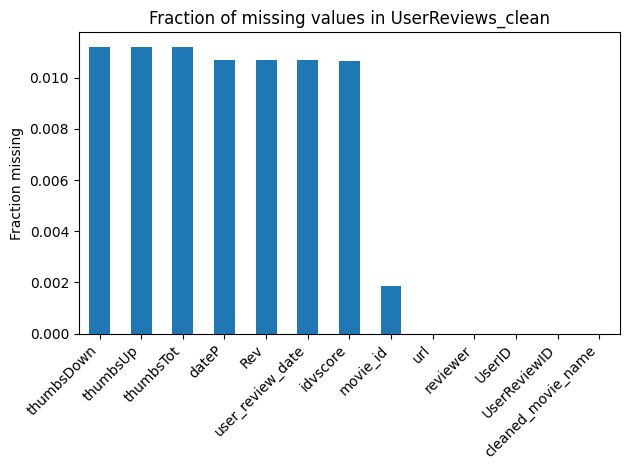

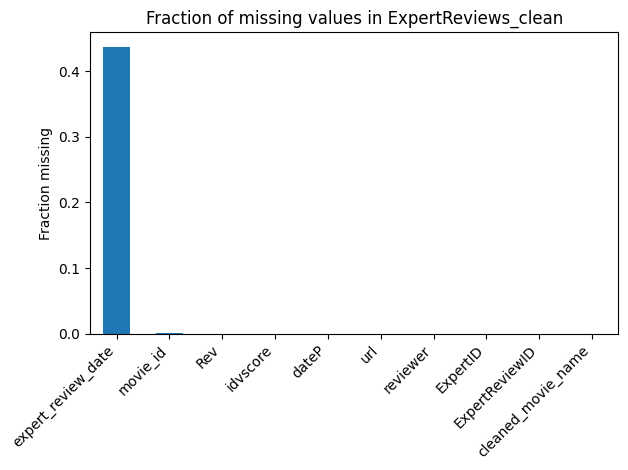

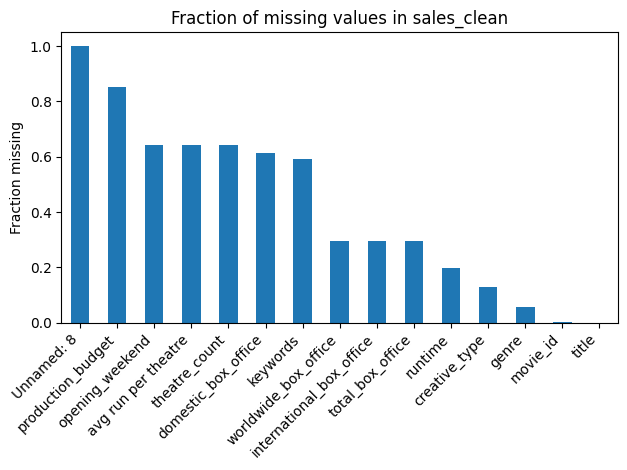

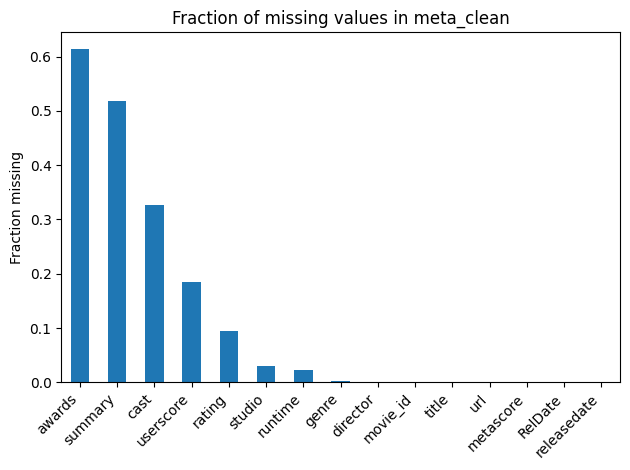

movie_key: no missing values in top 15 columns.


In [40]:
import matplotlib.pyplot as plt

def plot_missing(df, name, top_n=15):
    missing = df.isna().mean().sort_values(ascending=False).head(top_n)
    if missing.sum() == 0:
        print(f"{name}: no missing values in top {top_n} columns.")
        return

    plt.figure()
    missing.plot(kind="bar")
    plt.title(f"Fraction of missing values in {name}")
    plt.ylabel("Fraction missing")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

for name, df in cleaned_datasets.items():
    plot_missing(df, name)


Wat jullie allebei doen (dus: goed bezig)

Bij de docent zie je ongeveer deze structuur: introductie → “Read and clean data” → dataset inladen → kolomnamen fixen → dtypes goedzetten → missing values checken → eerste verkenning met tabellen en grafieken en daar tekst bij schrijven.

In jouw notebook zie ik:

Een duidelijke titel en uitleg:
“Metacritic project – EDA & data cleaning” met een lijstje van de stappen (load raw files, quick EDA, cleaning pipeline, ready for modelling).

Imports die lijken op die van de docent (numpy, pandas, plotnine, os, enzovoort).

Een sectie “Load raw data / Read the raw Excel files” waarin je uitlegt waar de bestanden staan en je alle vier de Excel-bestanden inleest in DataFrames.

Een quick overview van de vormen van de tabellen (print van shapes, kolomnamen).

Een plan om daarna de volledige cleaning-pipeline van Database Management toe te passen (movie_key, opgeschoonde metacritic data, enzovoort).

Dat lijkt allemaal sterk op de werkwijze van je docent: eerst netjes uitleggen wat je gaat doen, dan de data lezen, snel verkennen, daarna “echte” cleaning en helpers.

Waar jij al professioneel bezig bent

Je beschrijft in woorden wat de main steps zijn,
niet alleen code plakken. Dat doet je docent ook met de uitleg van de default risk dataset en de variabelen.

Je gebruikt duidelijke headings (1. Load raw data, enzovoort), net zoals de docent “Read and clean data”, “EDA”, enz. gebruikt.

Qua “stijl” van een academische notebook zit je dus echt goed: mix van markdown-tekst, uitleg en codeblokken.

Wat de docent extra doet (en wat je nog kunt toevoegen)

De docent gaat daarna vrij ver in de EDA, bijvoorbeeld:

Beschrijft de target (default ja/nee) en laat een tabel zien met class verdeling.

Schrijft een stukje tekst over class imbalance en waarom dat belangrijk is.

Maakt helperfuncties zoals generate_freq_table en generate_freq_plot om snel verdelingen te plotten.

Maakt meerdere grafieken (histogrammen, density plots, boxplots) en zet er interpretatie onder: wat zien we, wat betekent het, waarom is dit nuttig voor het model?

Bij jou:

Je hebt al quick EDA (shapes, kolommen, missing values) en een nette cleaning-pipeline gepland, maar je zit nog niet op het niveau van “diepe” EDA met veel grafieken en interpretatie.

Je spreekt de “target” nog niet expliciet uit. Voor jouw project moet je op een gegeven moment zeggen:
bijvoorbeeld “We willen (bijvoorbeeld) worldwide_box_office voorspellen op basis van metascore, userscore en genre / studio / etc.”
en dan je EDA daarop richten.

Tip: om nog meer op de docent te lijken kun je:

Een korte paragraaf toevoegen in markdown:

“Business / modelling goal: we want to predict X based on Y.”

Een paar simpele plots maken:

histogram van metascore en userscore

histogram of boxplot van worldwide_box_office

scatterplot metascore vs worldwide_box_office

Onder elke grafiek 3–5 zinnen tekst met interpretatie, net zoals in haar notebook.

Klein stijlpuntje

In je notebook staat nu ook een heading als:

“New attempt of correctly clean the data!!!!!!!!!!”

Voor de eindversie zou ik dat even omschrijven naar iets neutralers, bijvoorbeeld:

“Revised data cleaning pipeline”

of “Final data cleaning setup”

Dat oogt net wat professioneler, maar inhoudelijk is het prima.

Kort antwoord: ja, jouw notebook lijkt qua structuur en aanpak duidelijk op die van je docent. Je hebt de goede opbouw (intro, data inladen, quick EDA, cleaning). Wat je vooral nog kunt toevoegen om nog dichter in de buurt te komen, zijn wat extra grafieken en tekst met interpretatie rond je gekozen target, zoals zij ook doet bij default risk.